In [ ]:
pip install transformers

In [ ]:
pip install google-cloud-storage --upgrade

In [ ]:
pip install gcsfs

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from google.colab import drive
from google.colab import auth
from google.cloud import storage
import pandas as pd
from PIL import Image
import os
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')
bucket_name = "bucket-tfg"
storage_client = storage.Client()
auth.authenticate_user()
bucket = storage_client.get_bucket(bucket_name)

Mounted at /content/drive


In [ ]:
!gsutil -m cp -r -n 'gs://bucket-tfg/Nutrition5k dataset/4ImatgesXMostra_224x224/*' /content/Imatges

In [ ]:
len(os.listdir('/content/Imatges'))

In [ ]:
# Carregar el model de l'entrenament 12
model = ViTForImageClassification.from_pretrained('/content/drive/MyDrive/Treball Final de Grau/Model google_vit mod (una sola sortida)/Entrenament 12 Nutrition5k')

# Carregar el feature extractor
model_name_or_path = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
# Carregar arxiu csv on es relaciona cada id de cada plat amb els CHO que continguin
csv1 = pd.read_csv('gs://bucket-tfg/Nutrition5k dataset/dish_metadata_cafe1.csv', on_bad_lines='skip', header=None)
csv2 = pd.read_csv('gs://bucket-tfg/Nutrition5k dataset/dish_metadata_cafe2.csv', on_bad_lines='skip', header=None)

# Creació d'una variable tipus diccionari on guardi elements per avaluar el model
featte = {'image': [], 'cho': [], 'id': [], 'output': [], 'e_abs': [], 'e_rel': []}
dtset = {'test': featte}

# Llista ids dels plats a avaluar (partició de test)
blob = bucket.get_blob('Nutrition5k dataset/test_ids.txt')
blob = blob.download_to_filename('test_ids')
with open('test_ids') as f:
    test_ids = f.read().splitlines()
test_ids = test_ids[::2]

root = '/content/Imatges/'

# V7
# Afegir direcció de les mostres a la partició de train
root = '/content/Imatges/'
for i in test_ids[::2]:
    index = ((csv1.loc[csv1[0] == i]).index.tolist())
    if len(index) > 0:
        index = index[0]
        if csv1[4][index] < 100.0:
          # En aquest cas no cal modificar els valors de cho dels plats
          cho = csv1[4][index]
          subpath = root + i
          if os.path.isdir('/content/Imatges/' + i) == True:
            llista_im = os.listdir('/content/Imatges/' + i)
            for im in llista_im:
                dtset['test']['image'].append('/content/Imatges/' + i + '/' + im)
                dtset['test']['cho'].append(cho)
                dtset['test']['id'].append(i)
          else:
            pass
    else:
        pass

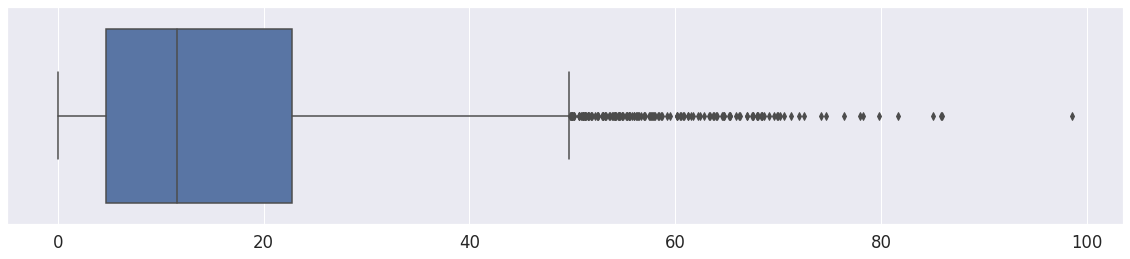

In [ ]:
# Caixa de dispersió dels valors de cho de les mostres de train
sns.set(rc={'figure.figsize':(20,4)}, font_scale = 1.5)
sns.boxplot(x=dtset['test']['cho'])

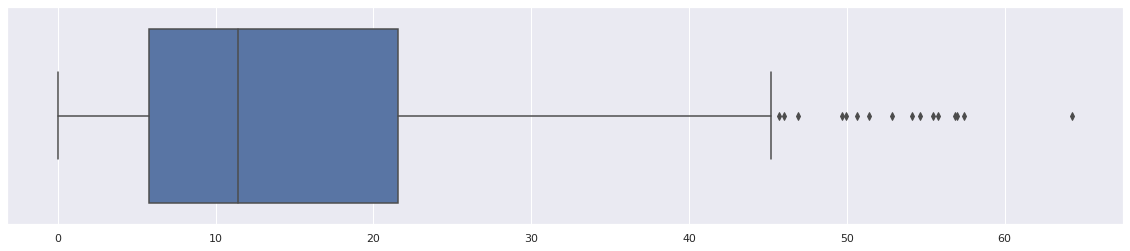

In [ ]:
# Caixa de dispersió dels valors de cho de les mostres de train
sns.set(rc={'figure.figsize':(20,4)})
sns.boxplot(x=dtset['test']['output'])

In [ ]:
# Inferència al model
for imatge in dtset['test']['image']:
  inputs = feature_extractor(images=Image.open(imatge), return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits
  if logits.item() > 0:
    dtset['test']['output'].append(round((logits.item()*100.0),6))
  else:
    dtset['test']['output'].append(0.0)

In [ ]:
# Carregar csv outputs i bolcar les dades en un diccionari
df = pd.read_csv('/content/drive/MyDrive/Treball Final de Grau/Model google_vit mod (una sola sortida)/Entrenament 12 Nutrition5k/outputs.csv')

# Creació d'una variable tipus diccionari on guardi elements per avaluar el model
featte = {'image': [], 'cho': [], 'id': [], 'output': [], 'e_abs': [], 'e_rel': []}
dtset = {'test': featte}

import ast
dtset['test']['cho'] = ast.literal_eval(df.loc[0][1])
dtset['test']['id'] = ast.literal_eval(df.loc[3][1])
dtset['test']['image'] = ast.literal_eval(df.loc[4][1])
dtset['test']['output'] = ast.literal_eval(df.loc[5][1])
dtset['test']['e_abs'] = ast.literal_eval(df.loc[1][1])
dtset['test']['e_rel'] = ast.literal_eval(df.loc[2][1])

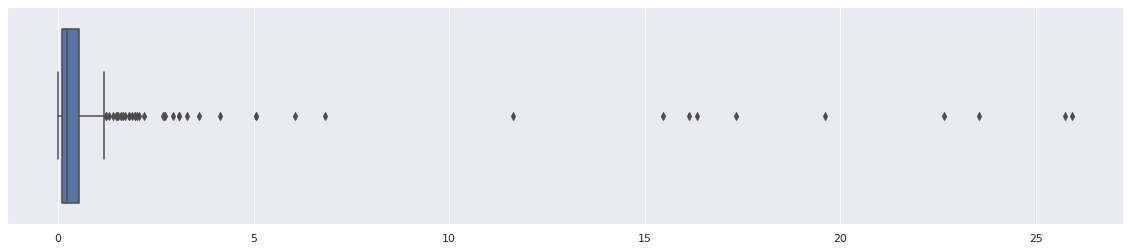

In [ ]:
# Caixa de dispersió de l'error relatiu
sns.set(rc={'figure.figsize':(20,4)})
sns.boxplot(x=dtset['test']['e_rel'])

In [ ]:
# Llista ids dels plats: test_ids
# cho reals: dtset['test']['cho']
# cho predits: dtset['test']['output']
# error absolut: dtset['test']['e_abs']
# error relatiu: dtset['test']['e_rel']
for i in range(len(dtset['test']['cho'])):
  dtset['test']['e_abs'].append(abs(dtset['test']['cho'][i]-dtset['test']['output'][i]))
  if dtset['test']['cho'][i] > 0:
    dtset['test']['e_rel'].append(abs(1.0-(dtset['test']['output'][i]/dtset['test']['cho'][i])))
  else:
    dtset['test']['e_rel'].append(0.0)

In [ ]:
len(dtset['test']['output']),len(dtset['test']['cho']),len(dtset['test']['image']),len(dtset['test']['id']),len(dtset['test']['e_abs']),len(dtset['test']['e_rel'])

(599, 599, 599, 599, 599, 599)

In [ ]:
# Guardar diccionari amb els outputs
df = pd.DataFrame.from_dict(dtset)
os.chdir('/content/drive/MyDrive/Treball Final de Grau/Model google_vit mod (una sola sortida)/Entrenament 12 Nutrition5k')
df.to_csv('/content/drive/MyDrive/Treball Final de Grau/Model google_vit mod (una sola sortida)/Entrenament 12 Nutrition5k/outputs.csv')

In [ ]:
# Mètriques

# Error Absolut Mig
mitj_err_abs = sum(dtset['test']['e_abs'])/len(dtset['test']['e_abs'])

# Error quadràtic mig
llista_err_quad = [x**2 for x in dtset['test']['e_abs']]
err_quad_mig = sum(llista_err_quad)/len(llista_err_quad)

# Error Relatiu Mig en %
mitj_err_rel = (mitj_err_abs/(sum(dtset['test']['cho'])/len(dtset['test']['cho'])))*100.0

# Desviació estàndard de l'error absolut
sd_err = statistics.pstdev(dtset['test']['e_abs'])

print(mitj_err_abs,err_quad_mig,mitj_err_rel,sd_err)

4.650751170283804 61.36726740445678 28.074401915794635 6.303790998800687


In [ ]:
# Llista d'ingredients

llista_ingred_plat = []
llista_ing_global = []
llista_rep_ing = []
llista_cho_ing = []
for i in range(len(csv1[0])):
    llista_ingred_plat = []
    llista_cho_plat = []
    sep = 0
    fi = False
    while fi == False:
        if sep < 119 and not(pd.isnull(csv1[7 + sep][i])):
            nom_ing = csv1[7 + sep][i]
            llista_ingred_plat.append(nom_ing)
            llista_cho_plat.append(csv1[11 + sep][i])
            sep += 7
        else:
            fi = True

    for ing in llista_ingred_plat:
        if ing not in llista_ing_global:
            llista_ing_global.append(ing)
            llista_rep_ing.append(1)
            llista_cho_ing.append(llista_cho_plat[llista_ingred_plat.index(ing)])
        else:
            llista_rep_ing[llista_ing_global.index(ing)] += 1
            llista_cho_ing[llista_ing_global.index(ing)] += llista_cho_plat[llista_ingred_plat.index(ing)]
            
for i in range(len(csv2[0])):
    llista_ingred_plat = []
    llista_cho_plat = []
    sep = 0
    fi = False
    while fi == False:
        if sep < 56 and not(pd.isnull(csv2[7 + sep][i])):
            nom_ing = csv2[7 + sep][i]
            llista_ingred_plat.append(nom_ing)
            llista_cho_plat.append(csv2[11 + sep][i])
            sep += 7
        else:
            fi = True

    for ing in llista_ingred_plat:
        if ing not in llista_ing_global:
            llista_ing_global.append(ing)
            llista_rep_ing.append(1)
            llista_cho_ing.append(llista_cho_plat[llista_ingred_plat.index(ing)])
        else:
            llista_rep_ing[llista_ing_global.index(ing)] += 1
            llista_cho_ing[llista_ing_global.index(ing)] += llista_cho_plat[llista_ingred_plat.index(ing)]

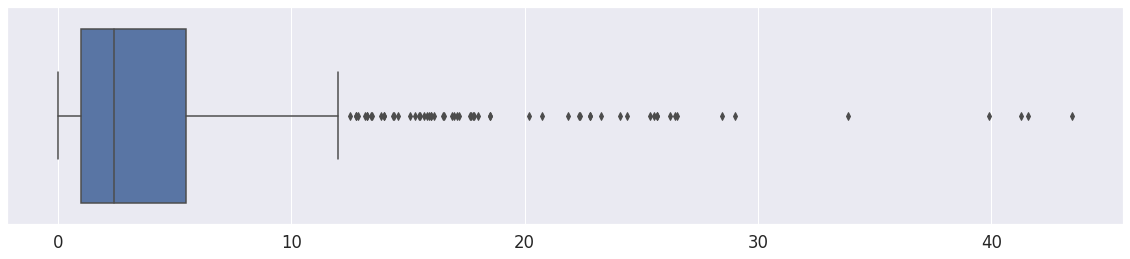

In [ ]:
# Caixa de dispersió de l'error absolut
sns.set(rc={'figure.figsize':(20,4)},font_scale=1.5)
sns.boxplot(x=dtset['test']['e_abs'])

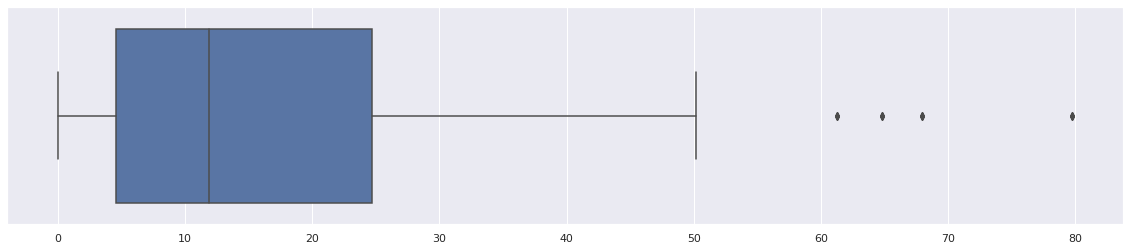

In [ ]:
# Caixa de dispersió dels valors de cho de les dades del conjunt de test
sns.set(rc={'figure.figsize':(20,4)})
sns.boxplot(x=dtset['test']['cho'])

Text(0.5, 0, 'Quantitat de carbohidrats (g)')

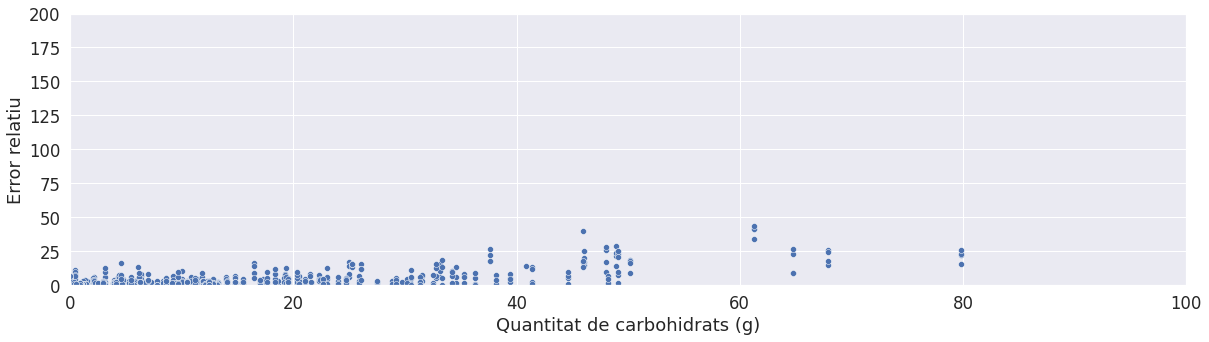

In [ ]:
# Scatterplot error relatiu / quantitat de cho
sns.set(rc={'figure.figsize':(20,5)},font_scale=1.5)
plot = sns.scatterplot(x=dtset['test']['cho'],y=dtset['test']['e_abs'])
plt.xlim(0,100),plt.ylim(0,200)
plot.set_ylabel('Error relatiu')
plot.set_xlabel('Quantitat de carbohidrats (g)')

In [ ]:
# Ingredients que provoquen errors més grans

# Diccionari creat a partir dels noms dels ingredients, on s'hi guardarà per 
# cada ingredient una llista d'errors en les prediccions del model en plats que 
# hi apareixen
err_ing = dict([(i,[]) for i in llista_ing_global])

for run in range(len(llista_ing_global)):
    for i in llista_ing_global:
        err_ing.setdefault(i,[])

llista_ingred_plat = []

for i in range(len(csv1[0])):
  sep = 0
  fi = False
  while fi == False:
    if sep < 119 and not(pd.isnull(csv1[7 + sep][i])):
      nom_ing = csv1[7 + sep][i]
      for j in range(len(dtset['test']['id'])):
        if dtset['test']['id'][j] == csv1[0][i]:
          err_ing[nom_ing].append(dtset['test']['e_abs'][j])
      sep += 7
    else:
        fi = True

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

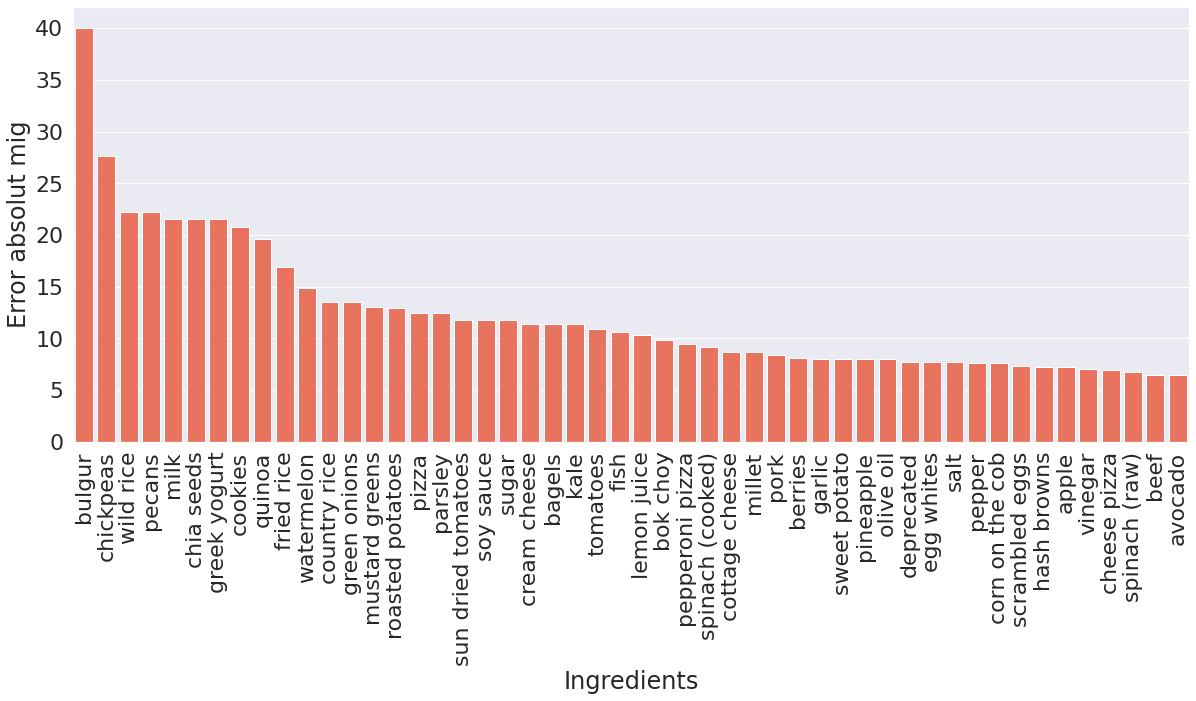

In [ ]:
# Llista d'ingredients presents en les mostres
llista_ing_presents = []
for ingredient in llista_ing_global:
  if len(err_ing[ingredient]) > 0:
    llista_ing_presents.append(ingredient)
  else:
    pass

# barplot ingredients / error mig
df = pd.DataFrame({"Ingredients":llista_ing_presents,"Error absolut mig":[sum(err_ing[x])/len(err_ing[x]) for x in err_ing if len(err_ing[x]) > 0.0]})
sns.set(rc={'figure.figsize':(20,8)},font_scale = 2)
barplot = sns.barplot(x='Ingredients',y='Error absolut mig',data=df,color='tomato',order=df.sort_values('Error absolut mig',ascending = False).Ingredients[0:50])
plt.xticks(rotation=90)

In [ ]:
# Diccionari d'errors absoluts mig organitzats en funció del nombre d'ingredients presents en el plat
err_per_num_ing = dict([(i,[]) for i in range(1,18)])

# Error absolut mig en funció del nombre d'ingredients del plat
for i in range(len(dtset['test']['id'])):
  index = csv1.index[csv1[0] == dtset['test']['id'][i]].item()
  sep = 0
  fi = False
  num_ing = 0
  while fi == False:
    if sep < 119 and not(pd.isnull(csv1[7 + sep][index])):
      num_ing += 1
      sep += 7
    else:
        fi = True
  err_per_num_ing[num_ing].append(dtset['test']['e_abs'][i])

llista_eAbsMig_nPlats = []
for i in range(1,18):
  if len(err_per_num_ing[i]) > 0:
    llista_eAbsMig_nPlats.append(sum(err_per_num_ing[i])/len(err_per_num_ing[i]))
  else:
    llista_eAbsMig_nPlats.append(0.0)

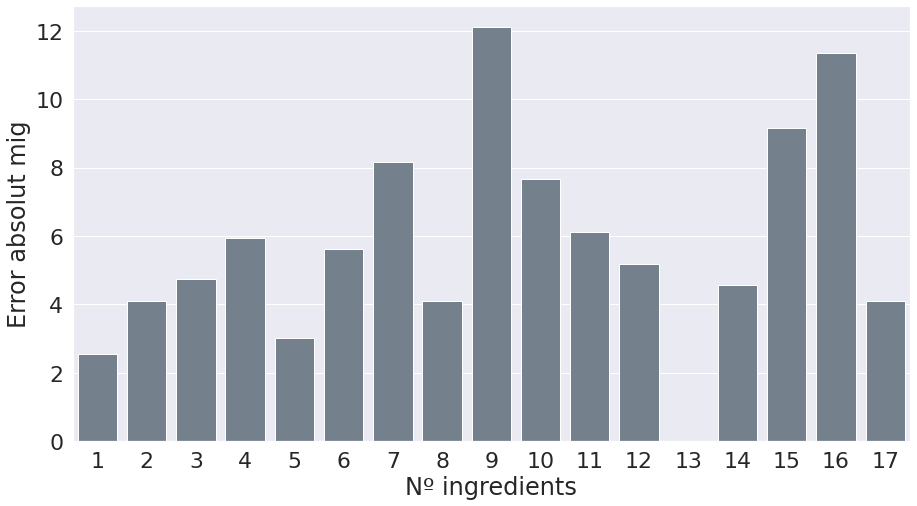

In [ ]:
# barplot Nº ingredients / error mig
df = pd.DataFrame({"Nº ingredients":[i for i in range(1,18)],"Error absolut mig":llista_eAbsMig_nPlats})
sns.set(rc={'figure.figsize':(15,8)},font_scale=2)
barplot = sns.barplot(x='Nº ingredients',y='Error absolut mig',data=df,color='slategrey')

In [ ]:
llista_num_plats = []
llista_MAE = []
nombre_imatgesXplat = 4

for ingredient in llista_ing_global:
  num_plat_present = 0
  llista_errors_abs = []
  for id in dtset['test']['id'][::nombre_imatgesXplat]:
    index = csv1.index[csv1[0] == id].item()

    llista_ingred_plat = []
    sep = 0
    fi = False
    while fi == False:
        if sep < 119 and not(pd.isnull(csv1[7 + sep][index])):
            nom_ing = csv1[7 + sep][index]
            llista_ingred_plat.append(nom_ing)
            sep += 7
        else:
            fi = True
    if ingredient in llista_ingred_plat:
      num_plat_present += 1
      llista_errors_abs.append(dtset['test']['e_abs'][dtset['test']['id'].index(id)])
  if num_plat_present > 0:
    llista_num_plats.append(num_plat_present)
    llista_MAE.append(sum(llista_errors_abs)/len(llista_errors_abs))

Text(0.5, 0, 'Nombre de plats en què apareix l ingredient')

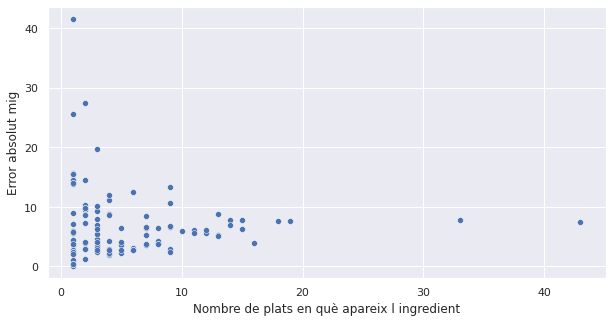

In [ ]:
# Error absolut mig per ingredient en funció del nombre de plats en què hi apareix
# CAL ESPECIFICAR EL NOMBRE DE IMATGES PER PLAT PRESENTS EN EL CONJUNT DE DADES
# Scatterplot
sns.set(rc={'figure.figsize':(10,5)},font_scale=1)
plot = sns.scatterplot(x=llista_num_plats,y=llista_MAE)
plot.set_ylabel('Error absolut mig')
plot.set_xlabel('Nombre de plats en què apareix l ingredient')

In [ ]:
# Error absolut en funció de la densitat de cho
llista_dens_cho = []
for i in range(len(dtset['test']['cho'])):
  index = ((csv1.loc[csv1[0] == dtset['test']['id'][i]]).index.tolist())
  llista_dens_cho.append(round(dtset['test']['cho'][i]/csv1[2][index].item(),5))

Text(0.5, 0, 'Densitat de carbohidrats ')

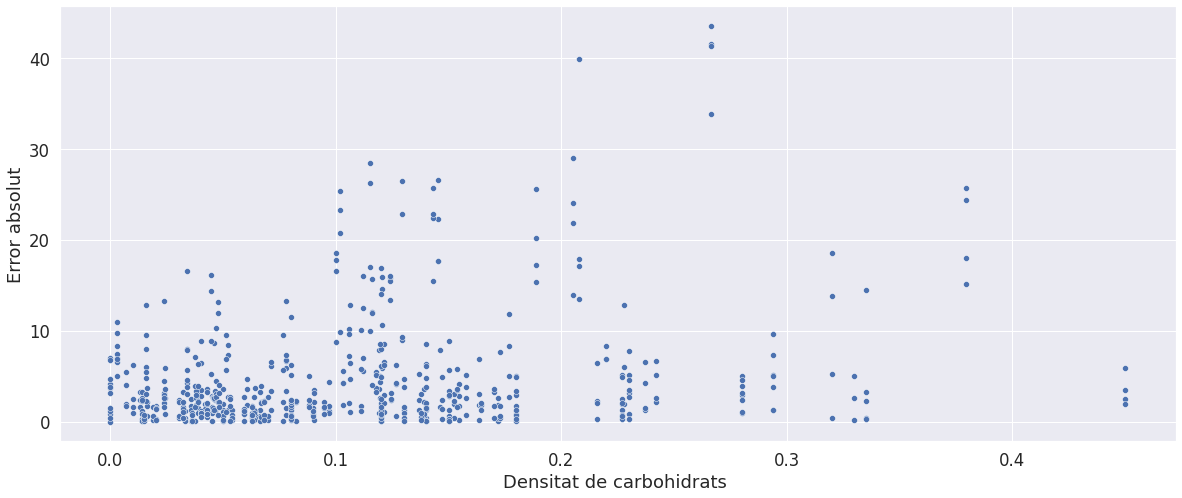

In [ ]:
# Scatterplot error relatiu / quantitat de cho
sns.set(rc={'figure.figsize':(20,8)},font_scale=1.5)
plot = sns.scatterplot(x=llista_dens_cho,y=dtset['test']['e_abs'])
plot.set_ylabel('Error absolut')
plot.set_xlabel('Densitat de carbohidrats ')

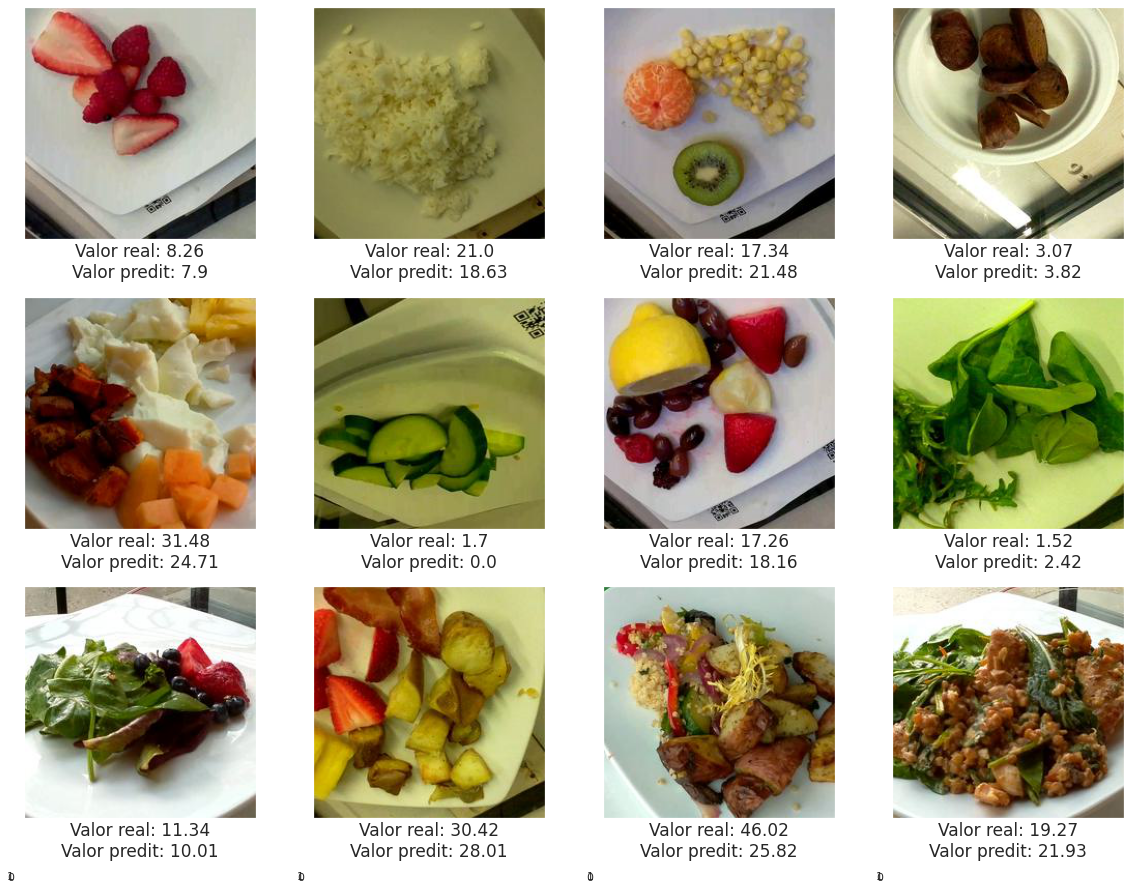

In [ ]:
# Exemples d'imatges amb les estimacions i els valors reals de cho
from mpl_toolkits.axes_grid1 import ImageGrid

# Llista d'imatges a utilitzar
# Imatge a utilitzar: [6,9,18,22,43,46,52,58,60,65,69,83]
# Males imatges: [34,75,82,110]
llista_imatges = []
llista_cho = []
llista_outputs = []
for i in [6,9,18,22,43,46,52,58,60,65,69,83]:
  llista_imatges.append(Image.open(dtset['test']['image'][i]))
  llista_cho.append(dtset['test']['cho'][i])
  llista_outputs.append(dtset['test']['output'][i])

fig = plt.figure(figsize=(30., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes,
                 axes_pad=0.8,  # pad between axes in inch.
                 label_mode = 'all'
                 )

for ax, im, cho, output in zip(grid, llista_imatges,llista_cho,llista_outputs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.grid(False)
    ax.set_xlabel('Valor real: ' + str(round(cho,2)) + '\n' + 'Valor predit: ' + str(round(output,2)), fontsize = 17)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

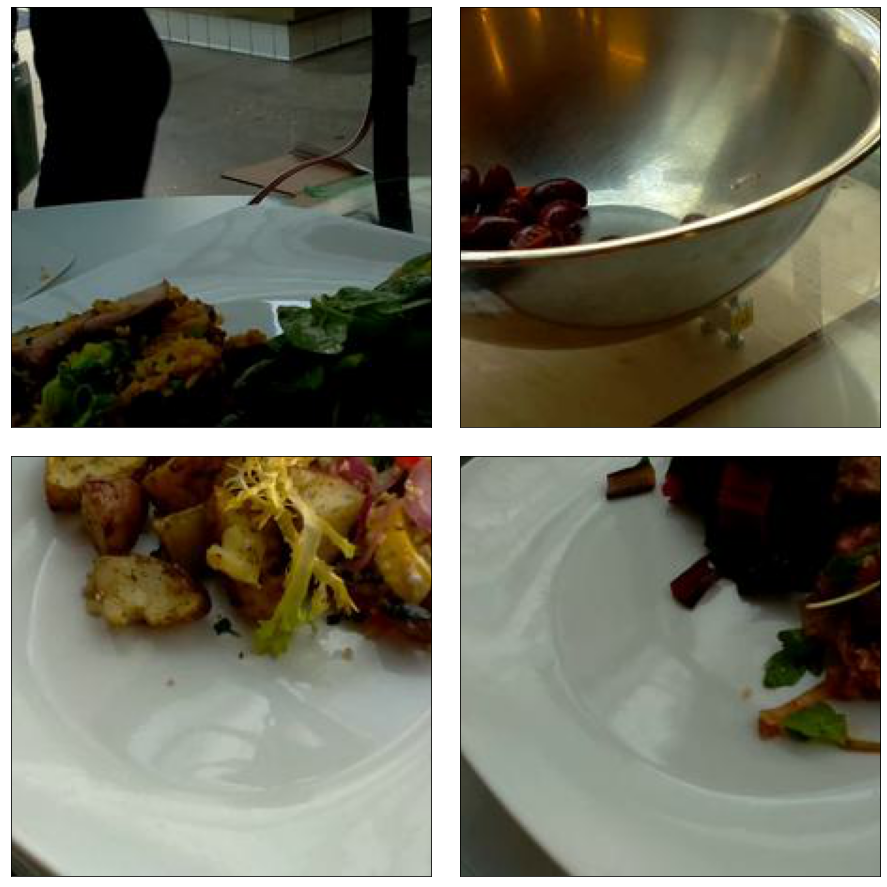

In [ ]:
# Exemples de males imatges
# Exemples d'imatges amb les estimacions i els valors reals de cho
from mpl_toolkits.axes_grid1 import ImageGrid

# Llista d'imatges a utilitzar
# Males imatges: [34,75,82,110]
llista_imatges = []
for i in [34,75,69,111]:
  llista_imatges.append(Image.open(dtset['test']['image'][i]))

fig = plt.figure(figsize=(30., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes,
                 axes_pad=0.4,  # pad between axes in inch.
                 label_mode = 'all'
                 )

for ax, im in zip(grid, llista_imatges):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.grid(False)
    # ax.set_xlabel('Valor real: ' + str(round(cho,2)) + '\n' + 'Valor predit: ' + str(round(output,2)), fontsize = 17)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Llista d'imatges a utilitzar per a apartat PCA
# Imatges a utilitzar de dtset: [8,9,10,11]maduixes [16,17,18,19]arros blanc [45,46,47,48]amanida amb pollastre [87,88,89,90]espinacs
llista_imatges = []
for i in [8,9,10,11,124,125,126,127,45,46,47,48,87,88,89,90]:
  llista_imatges.append(Image.open(dtset['test']['image'][i]))

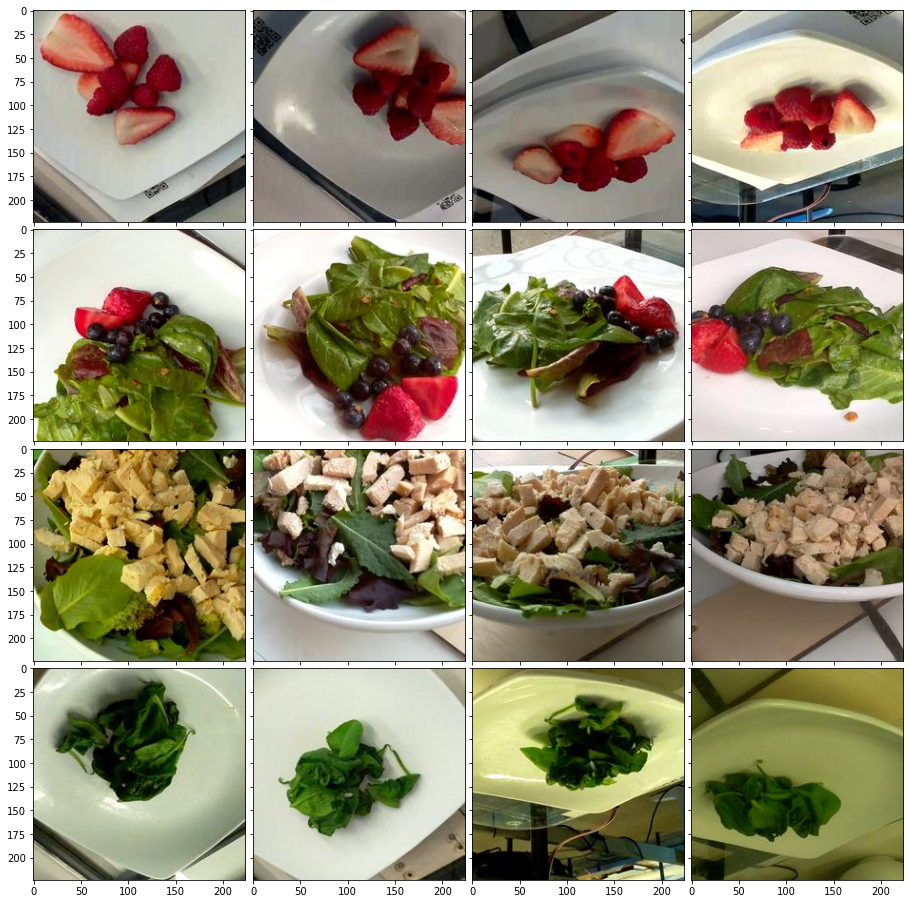

In [ ]:
# Imatges a utilitzar per l'apartat PCA
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(30., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes,
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, llista_imatges):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [ ]:
# Visualització dels vectors de sortida del transformer a través de PCA

# Inferència al model
inputs = feature_extractor(images=llista_imatges, return_tensors="pt")
outputs = model(**inputs,output_hidden_states=True)
logits = outputs.logits

# Llista de vectors
llista_vectors_norm = []
for i in range(len(outputs[1][12])):
  vector = outputs[1][12][i][196]
  # Estandaritzar vector
  vector = vector.detach().numpy()
  vector = vector.reshape(-1, 1)
  # vector = StandardScaler().fit_transform(vector)
  llista_vectors_norm.append(vector)

array = np.array(llista_vectors_norm)
array = array[:,:,0]

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(array)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['id'] = [dtset['test']['id'][id] for id in [8,9,10,11,124,125,126,127,45,46,47,48,87,88,89,90]]

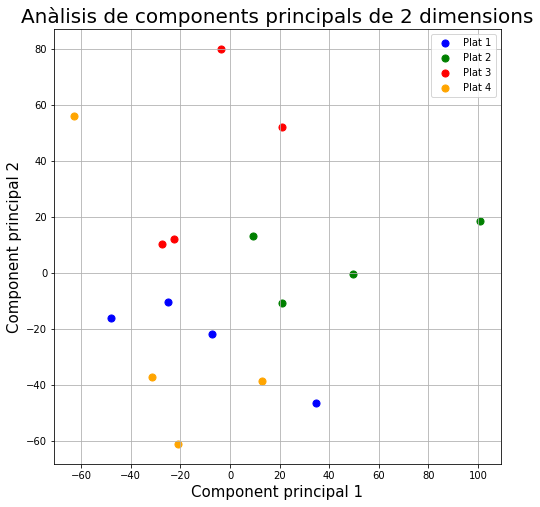

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component principal 1', fontsize = 15)
ax.set_ylabel('Component principal 2', fontsize = 15)
ax.set_title('Anàlisis de components principals de 2 dimensions', fontsize = 20)

# Llista de ids úniques en el rang
llista_unica = []
for x in principalDf['id']:
  if x not in llista_unica:
    llista_unica.append(x)
targets = llista_unica

colors = ['b', 'g', 'r', 'orange', 'm', 'c', 'k', 'w']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['id'] == target
    ax.scatter(principalDf.loc[indicesToKeep,'principal component 1']
               , principalDf.loc[indicesToKeep,'principal component 2']
               , c = color
               , s = 50)
ax.legend(['Plat 1','Plat 2','Plat 3','Plat 4'])
ax.grid()